# RESULTS Poker DVS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tonic, torch, os
from hots.network import network
from hots.utils import apply_jitter, get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [3]:
kfold = None

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset)
trainloader = get_loader(trainset)
testloader = get_loader(testset)
num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

number of samples in the training set: 48
number of samples in the testing set: 20


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-06-10'
dataset_name = 'poker'

Rz = [2, 4]
N_neuronz = [8, 16]
tauz = [1e3, 4e3]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False)

initial_name_nohomeo = hots_nohomeo.name

device -> cuda
device -> cuda


## Unsupervised clustering (Figure 4)

In [5]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering)
path_nohomeo = '../Records/networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering)

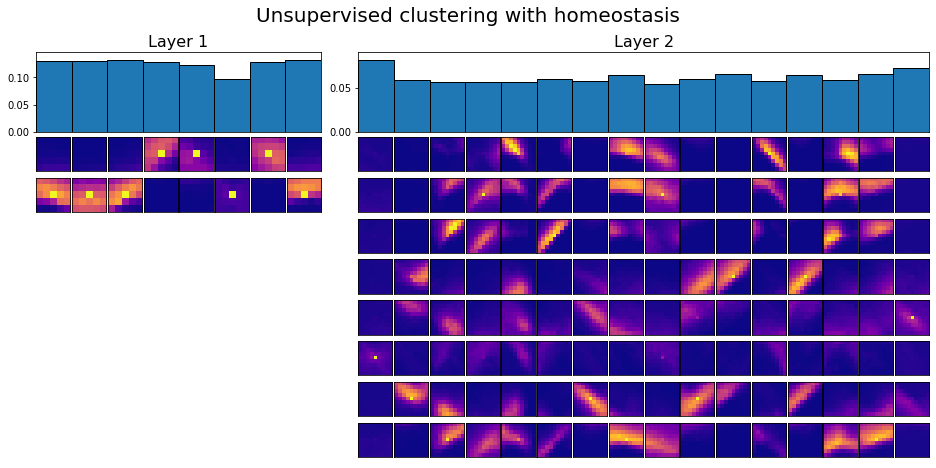

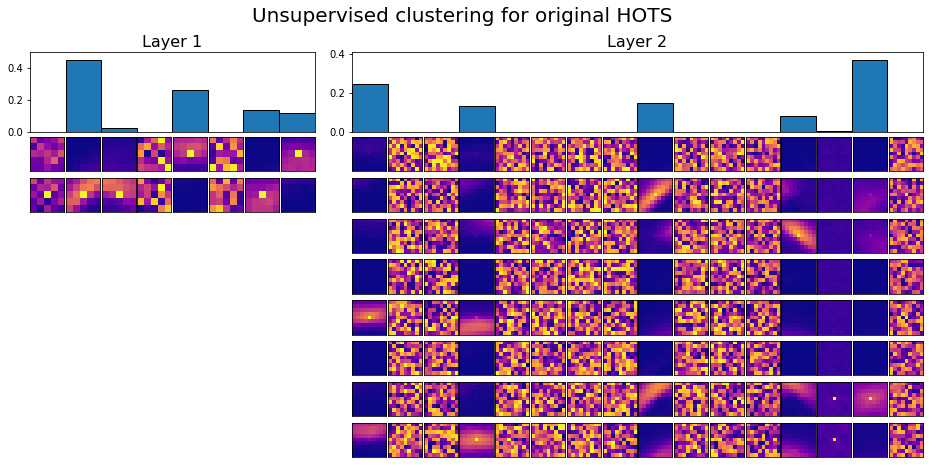

In [6]:
hots.plotlayers();
hots_nohomeo.plotlayers();

## Training of the classification layer

In [7]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 3e4

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, verbose=False)

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)

train_path_nohomeo = f'../Records/output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
model_path_nohomeo = f'../Records/networks/{hots_nohomeo.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
test_path_nohomeo = f'../Records/output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

hots_nohomeo.coding(testloader, testset.ordering, testset.classes, training=False, jitter=jitter, verbose=False)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

device -> cuda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [11:16<00:00, 20.51s/it]


## Online Inference (Figure 5-(a))

device -> cuda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23it/s]


Mean accuracy: 97.1%
last accuracy: 100.0%


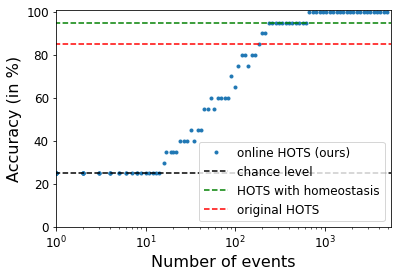

In [8]:
likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testoutputloader,results_path,ts_size,testset_output.ordering)
score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
score_nohomeo = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])
meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, figure_name = 'poker_online.pdf')
print(f'last accuracy: {lastac*100}%')

## Robustness to spatial jitter (Figure 6-(a)-(up))

In [ ]:
standard_spatial_jitter_min = 0
standard_spatial_jitter_max = 10
apply_jitter(standard_spatial_jitter_min, standard_spatial_jitter_max, 'spatial', num_sample_test, n_classes, hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, verbose=True);

  0%|                                                                                                                                                         | 0/10 [00:00<?, ?it/s]

../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(None, None)/
device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]


For spatial jitter equal to 0.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 85.0 %
HOTS with homeostasis accuracy: 95.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(0.27700831024930744, None)/
device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]


For spatial jitter equal to 0.27700831024930744
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 80.0 %
HOTS with homeostasis accuracy: 100.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(1.1080332409972298, None)/
device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]


For spatial jitter equal to 1.1080332409972298
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 80.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(2.4930747922437675, None)/
device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.29it/s]


For spatial jitter equal to 2.4930747922437675
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 45.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(4.432132963988919, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.28it/s]


For spatial jitter equal to 4.432132963988919
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 30.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(6.925207756232686, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


For spatial jitter equal to 6.925207756232686
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(9.97229916897507, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


For spatial jitter equal to 9.97229916897507
Online HOTS accuracy: 70.0 %
Original HOTS accuracy: 40.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(13.573407202216066, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.34it/s]


For spatial jitter equal to 13.573407202216066
Online HOTS accuracy: 65.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(17.728531855955676, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.34it/s]


For spatial jitter equal to 17.728531855955676
Online HOTS accuracy: 70.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(22.437673130193904, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.36it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.99it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.36it/s]


For spatial jitter equal to 22.437673130193904
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(27.700831024930743, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.38it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.38it/s]


For spatial jitter equal to 27.700831024930743
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(33.5180055401662, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.41it/s]


For spatial jitter equal to 33.5180055401662
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(39.88919667590028, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.43it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.43it/s]


For spatial jitter equal to 39.88919667590028
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(46.81440443213296, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.47it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.46it/s]


For spatial jitter equal to 46.81440443213296
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(54.29362880886426, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.38it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.49it/s]


For spatial jitter equal to 54.29362880886426
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(62.32686980609418, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.54it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.52it/s]


For spatial jitter equal to 62.32686980609418
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 15.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(70.9141274238227, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.59it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.30it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.59it/s]


For spatial jitter equal to 70.9141274238227
Online HOTS accuracy: 55.00000000000001 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(80.05540166204986, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.62it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.62it/s]


For spatial jitter equal to 80.05540166204986
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(89.75069252077562, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.65it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.67it/s]


For spatial jitter equal to 89.75069252077562
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_0_20_(100.0, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.48it/s]

 10%|██████████████▏                                                                                                                               | 1/10 [11:06<1:40:02, 666.92s/it]

For spatial jitter equal to 100.0
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


For spatial jitter equal to 0.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 85.0 %
HOTS with homeostasis accuracy: 95.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(0.27700831024930744, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.25it/s]


For spatial jitter equal to 0.27700831024930744
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 80.0 %
HOTS with homeostasis accuracy: 100.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(1.1080332409972298, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.20it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.24it/s]


For spatial jitter equal to 1.1080332409972298
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 95.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(2.4930747922437675, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.23it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]


For spatial jitter equal to 2.4930747922437675
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 50.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(4.432132963988919, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.26it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.24it/s]


For spatial jitter equal to 4.432132963988919
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 35.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(6.925207756232686, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.21it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


For spatial jitter equal to 6.925207756232686
Online HOTS accuracy: 75.0 %
Original HOTS accuracy: 45.0 %
HOTS with homeostasis accuracy: 30.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(9.97229916897507, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


For spatial jitter equal to 9.97229916897507
Online HOTS accuracy: 65.0 %
Original HOTS accuracy: 40.0 %
HOTS with homeostasis accuracy: 30.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(13.573407202216066, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


For spatial jitter equal to 13.573407202216066
Online HOTS accuracy: 60.0 %
Original HOTS accuracy: 40.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(17.728531855955676, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.34it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.34it/s]


For spatial jitter equal to 17.728531855955676
Online HOTS accuracy: 55.00000000000001 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(22.437673130193904, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.35it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.36it/s]


For spatial jitter equal to 22.437673130193904
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(27.700831024930743, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.37it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.36it/s]


For spatial jitter equal to 27.700831024930743
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(33.5180055401662, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.41it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]


For spatial jitter equal to 33.5180055401662
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(39.88919667590028, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.43it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]


For spatial jitter equal to 39.88919667590028
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(46.81440443213296, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.46it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.23it/s]


For spatial jitter equal to 46.81440443213296
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(54.29362880886426, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.08it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.08it/s]


For spatial jitter equal to 54.29362880886426
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 10.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(62.32686980609418, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.11it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.10it/s]


For spatial jitter equal to 62.32686980609418
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(70.9141274238227, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.14it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


For spatial jitter equal to 70.9141274238227
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 15.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(80.05540166204986, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.24it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.17it/s]


For spatial jitter equal to 80.05540166204986
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(89.75069252077562, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.78it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]


For spatial jitter equal to 89.75069252077562
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(100.0, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.24it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.85it/s]

 20%|████████████████████████████▍                                                                                                                 | 2/10 [25:18<1:43:22, 775.30s/it]

For spatial jitter equal to 100.0
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.05s/it]


For spatial jitter equal to 0.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 85.0 %
HOTS with homeostasis accuracy: 95.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(0.27700831024930744, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.07s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.08s/it]


For spatial jitter equal to 0.27700831024930744
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 75.0 %
HOTS with homeostasis accuracy: 100.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(1.1080332409972298, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.38it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


For spatial jitter equal to 1.1080332409972298
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 75.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(2.4930747922437675, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.07s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


For spatial jitter equal to 2.4930747922437675
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 45.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(4.432132963988919, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.07s/it]


For spatial jitter equal to 4.432132963988919
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 45.0 %
HOTS with homeostasis accuracy: 45.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(6.925207756232686, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.38it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.07s/it]


For spatial jitter equal to 6.925207756232686
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 40.0 %
HOTS with homeostasis accuracy: 30.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(9.97229916897507, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.05s/it]


For spatial jitter equal to 9.97229916897507
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 45.0 %
HOTS with homeostasis accuracy: 30.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(13.573407202216066, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.03s/it]


For spatial jitter equal to 13.573407202216066
Online HOTS accuracy: 65.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(17.728531855955676, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.02s/it]


For spatial jitter equal to 17.728531855955676
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(22.437673130193904, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.03s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.03s/it]


For spatial jitter equal to 22.437673130193904
Online HOTS accuracy: 55.00000000000001 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(27.700831024930743, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.01s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.70s/it]


For spatial jitter equal to 27.700831024930743
Online HOTS accuracy: 55.00000000000001 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(33.5180055401662, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.55s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


For spatial jitter equal to 33.5180055401662
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(39.88919667590028, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.50it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.04it/s]


For spatial jitter equal to 39.88919667590028
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(46.81440443213296, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.05it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.05it/s]


For spatial jitter equal to 46.81440443213296
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(54.29362880886426, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.09it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.58it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.08it/s]


For spatial jitter equal to 54.29362880886426
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 15.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(62.32686980609418, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.12it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.61it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.09it/s]


For spatial jitter equal to 62.32686980609418
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(70.9141274238227, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.16it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.14it/s]


For spatial jitter equal to 70.9141274238227
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(80.05540166204986, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.18it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.16it/s]


For spatial jitter equal to 80.05540166204986
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(89.75069252077562, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.21it/s]


For spatial jitter equal to 89.75069252077562
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(100.0, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.25it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.82it/s]

 30%|██████████████████████████████████████████▌                                                                                                   | 3/10 [43:54<1:48:37, 931.08s/it]

For spatial jitter equal to 100.0
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.37it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


For spatial jitter equal to 0.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 85.0 %
HOTS with homeostasis accuracy: 95.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(0.27700831024930744, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.05s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.38it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.07s/it]


For spatial jitter equal to 0.27700831024930744
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 85.0 %
HOTS with homeostasis accuracy: 100.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(1.1080332409972298, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.38it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.07s/it]


For spatial jitter equal to 1.1080332409972298
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 80.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(2.4930747922437675, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


For spatial jitter equal to 2.4930747922437675
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 55.00000000000001 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(4.432132963988919, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.07s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


For spatial jitter equal to 4.432132963988919
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 45.0 %
HOTS with homeostasis accuracy: 45.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(6.925207756232686, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.07s/it]


For spatial jitter equal to 6.925207756232686
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(9.97229916897507, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.05s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


For spatial jitter equal to 9.97229916897507
Online HOTS accuracy: 70.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 30.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(13.573407202216066, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.05s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


For spatial jitter equal to 13.573407202216066
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(17.728531855955676, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


For spatial jitter equal to 17.728531855955676
Online HOTS accuracy: 55.00000000000001 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(22.437673130193904, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.03s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.02s/it]


For spatial jitter equal to 22.437673130193904
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(27.700831024930743, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.01s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.60s/it]


For spatial jitter equal to 27.700831024930743
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(33.5180055401662, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.60s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.50s/it]


For spatial jitter equal to 33.5180055401662
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 40.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(39.88919667590028, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it]


For spatial jitter equal to 39.88919667590028
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(46.81440443213296, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.14it/s]


For spatial jitter equal to 46.81440443213296
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(54.29362880886426, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.16it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.17it/s]


For spatial jitter equal to 54.29362880886426
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(62.32686980609418, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.20it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.20it/s]


For spatial jitter equal to 62.32686980609418
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 15.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(70.9141274238227, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.23it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]


For spatial jitter equal to 70.9141274238227
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(80.05540166204986, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.26it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.26it/s]


For spatial jitter equal to 80.05540166204986
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(89.75069252077562, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


For spatial jitter equal to 89.75069252077562
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(100.0, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.33it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]

 40%|███████████████████████████████████████████████████████▌                                                                                   | 4/10 [1:02:22<1:40:04, 1000.72s/it]

For spatial jitter equal to 100.0
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.01it/s]


For spatial jitter equal to 0.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 85.0 %
HOTS with homeostasis accuracy: 95.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(0.27700831024930744, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.00it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


For spatial jitter equal to 0.27700831024930744
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 80.0 %
HOTS with homeostasis accuracy: 100.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(1.1080332409972298, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.01it/s]


For spatial jitter equal to 1.1080332409972298
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 80.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(2.4930747922437675, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


For spatial jitter equal to 2.4930747922437675
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 55.00000000000001 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(4.432132963988919, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


For spatial jitter equal to 4.432132963988919
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 40.0 %
HOTS with homeostasis accuracy: 35.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(6.925207756232686, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


For spatial jitter equal to 6.925207756232686
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 40.0 %
HOTS with homeostasis accuracy: 30.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(9.97229916897507, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


For spatial jitter equal to 9.97229916897507
Online HOTS accuracy: 70.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(13.573407202216066, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.04it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]


For spatial jitter equal to 13.573407202216066
Online HOTS accuracy: 55.00000000000001 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(17.728531855955676, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.04it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.50it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.05it/s]


For spatial jitter equal to 17.728531855955676
Online HOTS accuracy: 55.00000000000001 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(22.437673130193904, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.05it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.06it/s]


For spatial jitter equal to 22.437673130193904
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(27.700831024930743, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.08it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.08it/s]


For spatial jitter equal to 27.700831024930743
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(33.5180055401662, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.10it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.10it/s]


For spatial jitter equal to 33.5180055401662
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(39.88919667590028, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.10it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.11it/s]


For spatial jitter equal to 39.88919667590028
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(46.81440443213296, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.15it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.13it/s]


For spatial jitter equal to 46.81440443213296
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(54.29362880886426, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.16it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.16it/s]


For spatial jitter equal to 54.29362880886426
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 15.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(62.32686980609418, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.20it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.20it/s]


For spatial jitter equal to 62.32686980609418
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(70.9141274238227, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.43it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.01it/s]


For spatial jitter equal to 70.9141274238227
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 15.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(80.05540166204986, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.06it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.61it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.05it/s]


For spatial jitter equal to 80.05540166204986
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(89.75069252077562, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.28it/s]


For spatial jitter equal to 89.75069252077562
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(100.0, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.34it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]

 50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 5/10 [1:19:01<1:23:20, 1000.13s/it]

For spatial jitter equal to 100.0
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.01it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.01it/s]


For spatial jitter equal to 0.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 85.0 %
HOTS with homeostasis accuracy: 95.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(0.27700831024930744, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


For spatial jitter equal to 0.27700831024930744
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 90.0 %
HOTS with homeostasis accuracy: 100.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(1.1080332409972298, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


For spatial jitter equal to 1.1080332409972298
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 55.00000000000001 %
HOTS with homeostasis accuracy: 85.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(2.4930747922437675, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.01it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.01it/s]


For spatial jitter equal to 2.4930747922437675
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 45.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(4.432132963988919, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.49it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


For spatial jitter equal to 4.432132963988919
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(6.925207756232686, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


For spatial jitter equal to 6.925207756232686
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 30.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(9.97229916897507, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


For spatial jitter equal to 9.97229916897507
Online HOTS accuracy: 65.0 %
Original HOTS accuracy: 45.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(13.573407202216066, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]


For spatial jitter equal to 13.573407202216066
Online HOTS accuracy: 70.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(17.728531855955676, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.04it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.49it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.04it/s]


For spatial jitter equal to 17.728531855955676
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(22.437673130193904, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.07it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.50it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.05it/s]


For spatial jitter equal to 22.437673130193904
Online HOTS accuracy: 55.00000000000001 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(27.700831024930743, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.09it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.07it/s]


For spatial jitter equal to 27.700831024930743
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(33.5180055401662, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.10it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.08it/s]


For spatial jitter equal to 33.5180055401662
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(39.88919667590028, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.12it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.09it/s]


For spatial jitter equal to 39.88919667590028
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(46.81440443213296, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.14it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.14it/s]


For spatial jitter equal to 46.81440443213296
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(54.29362880886426, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.16it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.16it/s]


For spatial jitter equal to 54.29362880886426
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(62.32686980609418, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.20it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.19it/s]


For spatial jitter equal to 62.32686980609418
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(70.9141274238227, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.23it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]


For spatial jitter equal to 70.9141274238227
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 15.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(80.05540166204986, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.62it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.62it/s]


For spatial jitter equal to 80.05540166204986
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(89.75069252077562, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.68it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.68it/s]


For spatial jitter equal to 89.75069252077562
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(100.0, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.52it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 6/10 [1:35:00<1:05:44, 986.18s/it]

For spatial jitter equal to 100.0
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


For spatial jitter equal to 0.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 85.0 %
HOTS with homeostasis accuracy: 95.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(0.27700831024930744, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.29it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.29it/s]


For spatial jitter equal to 0.27700831024930744
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 70.0 %
HOTS with homeostasis accuracy: 100.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(1.1080332409972298, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


For spatial jitter equal to 1.1080332409972298
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 90.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(2.4930747922437675, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


For spatial jitter equal to 2.4930747922437675
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 45.0 %
HOTS with homeostasis accuracy: 55.00000000000001 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(4.432132963988919, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


For spatial jitter equal to 4.432132963988919
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 45.0 %
HOTS with homeostasis accuracy: 35.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(6.925207756232686, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


For spatial jitter equal to 6.925207756232686
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 45.0 %
HOTS with homeostasis accuracy: 30.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(9.97229916897507, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


For spatial jitter equal to 9.97229916897507
Online HOTS accuracy: 60.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 30.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(13.573407202216066, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


For spatial jitter equal to 13.573407202216066
Online HOTS accuracy: 55.00000000000001 %
Original HOTS accuracy: 40.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(17.728531855955676, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.34it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.35it/s]


For spatial jitter equal to 17.728531855955676
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(22.437673130193904, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.35it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.36it/s]


For spatial jitter equal to 22.437673130193904
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(27.700831024930743, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.36it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.37it/s]


For spatial jitter equal to 27.700831024930743
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(33.5180055401662, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]


For spatial jitter equal to 33.5180055401662
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(39.88919667590028, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]


For spatial jitter equal to 39.88919667590028
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(46.81440443213296, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.47it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.45it/s]


For spatial jitter equal to 46.81440443213296
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 15.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(54.29362880886426, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.51it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.50it/s]


For spatial jitter equal to 54.29362880886426
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(62.32686980609418, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.52it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.52it/s]


For spatial jitter equal to 62.32686980609418
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(70.9141274238227, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.59it/s]


For spatial jitter equal to 70.9141274238227
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(80.05540166204986, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.63it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.64it/s]


For spatial jitter equal to 80.05540166204986
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(89.75069252077562, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.68it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]


For spatial jitter equal to 89.75069252077562
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(100.0, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.52it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7/10 [1:47:48<45:44, 914.98s/it]

For spatial jitter equal to 100.0
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.29it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


For spatial jitter equal to 0.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 85.0 %
HOTS with homeostasis accuracy: 95.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(0.27700831024930744, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.29it/s]


For spatial jitter equal to 0.27700831024930744
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 75.0 %
HOTS with homeostasis accuracy: 100.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(1.1080332409972298, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


For spatial jitter equal to 1.1080332409972298
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 60.0 %
HOTS with homeostasis accuracy: 85.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(2.4930747922437675, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


For spatial jitter equal to 2.4930747922437675
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 50.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(4.432132963988919, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


For spatial jitter equal to 4.432132963988919
Online HOTS accuracy: 75.0 %
Original HOTS accuracy: 50.0 %
HOTS with homeostasis accuracy: 30.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(6.925207756232686, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


For spatial jitter equal to 6.925207756232686
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 40.0 %
HOTS with homeostasis accuracy: 30.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(9.97229916897507, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


For spatial jitter equal to 9.97229916897507
Online HOTS accuracy: 70.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(13.573407202216066, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


For spatial jitter equal to 13.573407202216066
Online HOTS accuracy: 75.0 %
Original HOTS accuracy: 40.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(17.728531855955676, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.34it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.33it/s]


For spatial jitter equal to 17.728531855955676
Online HOTS accuracy: 60.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(22.437673130193904, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.36it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.36it/s]


For spatial jitter equal to 22.437673130193904
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(27.700831024930743, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.37it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.00it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.38it/s]


For spatial jitter equal to 27.700831024930743
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(33.5180055401662, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]


For spatial jitter equal to 33.5180055401662
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(39.88919667590028, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.44it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]


For spatial jitter equal to 39.88919667590028
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(46.81440443213296, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.47it/s]


device -> cuda



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.46it/s]


For spatial jitter equal to 46.81440443213296
Online HOTS accuracy: 60.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(54.29362880886426, None)/



  0%|                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

## Robustness to temporal jitter (Figure 6-(a)-(down))

In [ ]:
standard_temporal_jitter_min = 3
standard_temporal_jitter_max = 7
apply_jitter(standard_temporal_jitter_min, standard_temporal_jitter_max, 'temporal', num_sample_test, n_classes, hots,hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs)